In [3]:
import os

In [4]:
os.chdir('/vsc-hard-mounts/leuven-data/346/vsc34647/jupyterhub_notebooks/scATAC')

In [5]:
os.getcwd()

'/vsc-hard-mounts/leuven-data/346/vsc34647/jupyterhub_notebooks/scATAC'

In [6]:
files_dir = "/lustre1/project/stg_00002/lcb/lcb_projects/CRM_CROP_seq_multi/cellranger_arc/CRM__4f279b__c7fd7d__10x_Multiome_MCF_VPR_and_MM_KRAB_full_seq/outs/"

In [7]:
# Path to fragments
fragments_dict = {'CRM_CROP_seq_multi': files_dir + 'atac_fragments.tsv.gz'}    

In [8]:
fragments_dict

{'CRM_CROP_seq_multi': '/lustre1/project/stg_00002/lcb/lcb_projects/CRM_CROP_seq_multi/cellranger_arc/CRM__4f279b__c7fd7d__10x_Multiome_MCF_VPR_and_MM_KRAB_full_seq/outs/atac_fragments.tsv.gz'}

In [9]:
peaks_file = files_dir + "atac_peaks.bed"

In [10]:
tmpDir = '/scratch/leuven/346/vsc34647/tmp/'

In [11]:
outDir = '/vsc-hard-mounts/leuven-data/346/vsc34647/jupyterhub_notebooks/scATAC/'

# QC

Get TSS annotations

In [15]:
# Get TSS annotations
import pybiomart as pbm
# For human (hg38)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'].unique()
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
#annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

In [17]:
annot.head()
# if Chromosome values are not the same as in the fragments file, convert chr2 -> 2 etc.

,Chromosome,Start,Strand,Gene,Transcript_type
0,HG991_PATCH,66119285,1,SLC25A26,protein_coding
1,HG991_PATCH,66320895,1,SLC25A26,protein_coding
113,HG706_PATCH,75635873,-1,BTC,protein_coding
114,HG706_PATCH,75660403,-1,BTC,protein_coding
128,HG185_PATCH,39868578,1,GAST,protein_coding


Compute QC stats - needed to calculate all metrics

In [12]:
from pycisTopic.qc import *

metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = {'CRM_CROP_seq_multi': peaks_file},
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

2022-03-10 17:56:59,132	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8266


(compute_qc_stats_ray pid=29474) 2022-03-10 17:57:04,064 cisTopic     INFO     Reading CRM_CROP_seq_multi
(compute_qc_stats_ray pid=29474) 2022-03-10 18:00:53,769 cisTopic     INFO     Computing barcode rank plot for CRM_CROP_seq_multi
(compute_qc_stats_ray pid=29474) 2022-03-10 18:00:53,770 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=29474) 2022-03-10 18:01:03,854 cisTopic     INFO     Marking barcodes with more than 100
(compute_qc_stats_ray pid=29474) 2022-03-10 18:01:03,898 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=29474) 2022-03-10 18:01:03,901 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=29474) 2022-03-10 18:01:17,557 cisTopic     INFO     Computing duplicate rate plot for CRM_CROP_seq_multi
(compute_qc_stats_ray pid=29474) 2022-03-10 18:01:28,362 cisTopic     INFO     Return plot data
(compute_qc_stats_ray pid=29474) 2022-03-10 18:01:28,550 cisTopic     INFO     Computing insert size distribution for CR

Save metadata and profile_data_dict (compute_qc_stats output)

In [16]:
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
    pickle.dump(metadata_bc, f)
    
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
    pickle.dump(profile_data_dict, f)

Once the QC metrics have been computed you can visualize the results at the **sample-level** and the **barcode-level**. 
- Sample-level statistics can be used to assess the overall quality of the sample
- Barcode level statistics can be use to differentiate good quality cells versus the rest.

## Sample-level
- **Barcode rank plot**: The barcode rank plot shows the distribution of non-duplicate reads and which barcodes were inferred to be associated with cells. A steep drop-off ('knee') is indicative of good separation between the cell-associated barcodes and the barcodes associated with empty partitions.

- **Insertion size**: ATAC-seq requires a proper pair of Tn5 transposase cutting events at the ends of DNA. In the nucleosome-free open chromatin regions, many molecules of Tn5 can kick in and chop the DNA into small pieces; around nucleosome-occupied regions, and Tn5 can only access the linker regions. Therefore, in a good ATAC-seq library, you should expect to see a sharp peak at the <100 bp region (open chromatin), and a peak at ~200bp region (mono-nucleosome), and other larger peaks (multi-nucleosomes). A clear nucleosome pattern indicates a good quality of the experiment.

- **Sample TSS enrichment**: The TSS enrichment calculation is a signal to noise calculation. The reads around a reference set of TSSs are collected to form an aggregate distribution of reads centered on the TSSs and extending to 1000 bp in either direction (for a total of 2000bp). This distribution is then normalized by taking the average read depth in the 100 bps at each of the end flanks of the distribution (for a total of 200bp of averaged data) and calculating a fold change at each position over that average read depth. This means that the flanks should start at 1, and if there is high read signal at transcription start sites (highly open regions of the genome) there should be an increase in signal up to a peak in the middle.

- **FRIP distribution**: Fraction of all mapped reads that fall into the called peak regions, i.e. usable reads in significantly enriched peaks divided by all usable reads. In general, FRiP scores correlate positively with the number of regions. A low FRIP indicates that many reads form part of the background, and so that the data is noisy.

- **Duplication rate**: A fragment is considered “usable” if it uniquely maps to the genome and remains after removing PCR duplicates (defined as two fragments that map to the same genomic position and have the same unique molecular identifier). The duplication rate serves to estimate the amount of usable reads per barcode. High duplication rates may indicate over-sequencing or lack of fragments after transposition and encapsulation.

In [17]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol =5,
           plot =True,
           save = outDir + '/quality_control/sample_metrics.pdf')

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


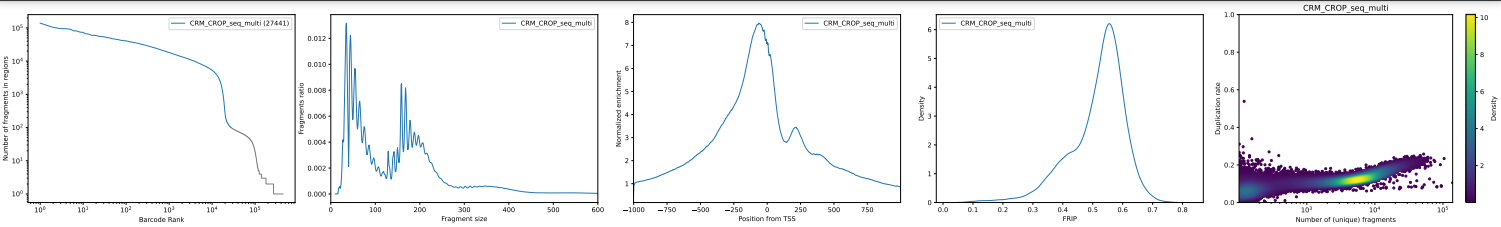

## Barcode-level

In [18]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['CRM_CROP_seq_multi'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.5,
                                       max_x=None,
                                       min_y=0.2,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['CRM_CROP_seq_multi'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=4,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['CRM_CROP_seq_multi'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distribut

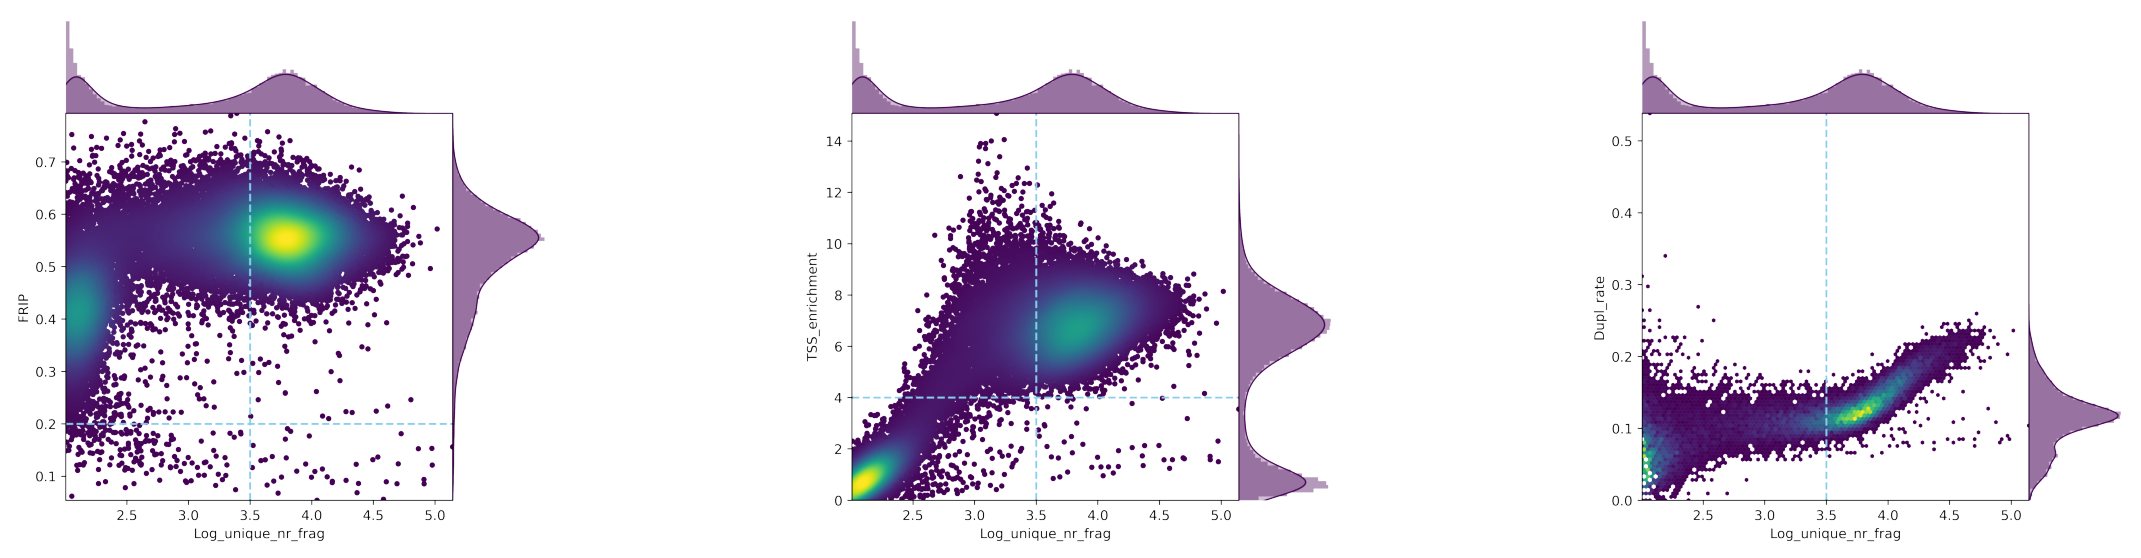

In [19]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()
plt.savefig(outDir + 'quality_control/FRIP_TSS_DR_combined.png')

Filter out noisy cells

In [20]:
bc_passing_filters = {'CRM_CROP_seq_multi':[]}
bc_passing_filters['CRM_CROP_seq_multi'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
len(bc_passing_filters['CRM_CROP_seq_multi'])

14071

In [ ]:
# # Get metadata from high-quality loom file
# from pycisTopic.loom import *
# path_to_annotated_rna_loom = projDir + 'output/rna/vsn/add_clusters_scrublet_as_annot/10x_multiome_brain_SCENIC_SCope_output_wAnnot_noDBL.loom'
# loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
# cell_data = get_metadata(loom)
# scRNA_bc=[re.sub("-10x_multiome_brain", "", x) for x in cell_data.index.tolist()]
# len(list(set(bc_passing_filters['10x_multiome_brain']) & set(scRNA_bc)))

In [21]:
import pickle 
with open(outDir + 'quality_control/bc_passing_filters.pkl', 'wb') as f:
    pickle.dump(bc_passing_filters, f)

# Create cisTopic object

In [22]:
# Path to regions
path_to_regions = peaks_file
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg19-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
# Valid barcodes
import pickle
infile = open(outDir + 'quality_control/bc_passing_filters.pkl', 'rb')
bc_passing_filters = pickle.load(infile)
infile.close()

#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=bc_passing_filters[key],
                                               n_cpu=1,
                                               project=key,
                                               split_pattern='-') for key in fragments_dict.keys()]

2022-03-11 12:27:28,244 cisTopic     INFO     Reading data for CRM_CROP_seq_multi
2022-03-11 12:30:59,666 cisTopic     INFO     metrics provided!
2022-03-11 12:31:10,399 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-03-11 12:31:20,467 cisTopic     INFO     Counting fragments in regions
2022-03-11 12:32:26,562 cisTopic     INFO     Creating fragment matrix
2022-03-11 12:32:55,932 cisTopic     INFO     Data is too big, making partitions. This is a reported error in Pandas versions > 0.21 (https://github.com/pandas-dev/pandas/issues/26314)
2022-03-11 12:33:36,018 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-03-11 12:33:43,251 cisTopic     INFO     Removing blacklisted regions
2022-03-11 12:33:44,179 cisTopic     INFO     Creating CistopicObject
2022-03-11 12:33:45,133 cisTopic     INFO     Done!
2022-03-11 12:34:08,595 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-03-11 12:34:15,632 cisTopic     INFO     Removing black

In [23]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project CRM_CROP_seq_multi with n_cells × n_regions = 14071 × 164675


Save cisTopic

In [24]:
with open(outDir + 'CROP_multiome_cisTopicObject.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)

# Add metadata to object

In [28]:
# Load cisTopic object
import pickle
infile = open(outDir + 'CROP_multiome_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

Use metadata from scRNAseq

In [30]:
import pandas as pd
scRNAseq_metadata = pd.read_csv("scRNAseq_metadata.csv")

In [31]:
scRNAseq_metadata.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.4,seurat_clusters
0,AAACAGCCAATGCGCT,CROP_multiome_RNA,3948,2236,0,0
1,AAACAGCCACAATACT,CROP_multiome_RNA,6826,3191,3,3
2,AAACAGCCACAGAAAC,CROP_multiome_RNA,8673,3825,1,1
3,AAACAGCCACATACTG,CROP_multiome_RNA,8215,3539,5,5
4,AAACAGCCACCCTCAC,CROP_multiome_RNA,3818,2119,2,2


In [32]:
scRNAseq_metadata.set_index("Unnamed: 0", inplace = True)

In [35]:
scRNAseq_metadata.head()

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.4,seurat_clusters
Unnamed: 0,,,,,
AAACAGCCAATGCGCT,CROP_multiome_RNA,3948,2236,0,0
AAACAGCCACAATACT,CROP_multiome_RNA,6826,3191,3,3
AAACAGCCACAGAAAC,CROP_multiome_RNA,8673,3825,1,1
AAACAGCCACATACTG,CROP_multiome_RNA,8215,3539,5,5
AAACAGCCACCCTCAC,CROP_multiome_RNA,3818,2119,2,2


In [42]:
cistopic_obj.add_cell_data(scRNAseq_metadata, split_pattern='-')

Columns ['orig.ident', 'nFeature_RNA', 'RNA_snn_res.0.4', 'nCount_RNA', 'seurat_clusters'] will be overwritten


In [61]:
cistopic_obj.cell_data.head()

,Unique_nr_frag,Dupl_rate,cisTopic_nr_frag,barcode,Total_nr_frag,cisTopic_log_nr_frag,Log_unique_nr_frag,sample_id,cisTopic_log_nr_acc,Unique_nr_frag_in_regions,...,cisTopic_nr_acc,TSS_enrichment,FRIP,Total_nr_frag_in_regions,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.4,seurat_clusters,Barcode
ATTGCTCGTCACCAAA-1-CRM_CROP_seq_multi,5935,0.127719,3013,ATTGCTCGTCACCAAA,6804,3.478999,3.773421,CRM_CROP_seq_multi,3.444669,3013,...,2784,8.542422,0.507666,3680,NaN,NaN,NaN,NaN,NaN,ATTGCTCGTCACCAAA-1
GGCGTTATCAAAGGCA-1-CRM_CROP_seq_multi,7747,0.130723,3877,GGCGTTATCAAAGGCA,8912,3.588496,3.889134,CRM_CROP_seq_multi,3.553762,3877,...,3579,5.496634,0.500452,4778,NaN,NaN,NaN,NaN,NaN,GGCGTTATCAAAGGCA-1
TATCACAAGACAGGTA-1-CRM_CROP_seq_multi,22452,0.149126,9438,TATCACAAGACAGGTA,26387,3.97488,4.351255,CRM_CROP_seq_multi,3.905742,9438,...,8049,6.774761,0.420363,12460,NaN,NaN,NaN,NaN,NaN,TATCACAAGACAGGTA-1
CCTGTTGGTGCGCATG-1-CRM_CROP_seq_multi,28284,0.186774,16447,CCTGTTGGTGCGCATG,34780,4.216087,4.451541,CRM_CROP_seq_multi,4.123688,16447,...,13295,6.548733,0.581495,22172,NaN,NaN,NaN,NaN,NaN,CCTGTTGGTGCGCATG-1
GTATTGCAGGTTAGAG-1-CRM_CROP_seq_multi,17441,0.182057,9790,GTATTGCAGGTTAGAG,21323,3.990783,4.241571,CRM_CROP_seq_multi,3.926754,9790,...,8448,7.268492,0.561321,13128,NaN,NaN,NaN,NaN,NaN,GTATTGCAGGTTAGAG-1


In [57]:
cistopic_obj.cell_data['barcode'] = cistopic_obj.cell_data['barcode'].apply(lambda x: x.replace('-1',''))

In [62]:
#cistopic_obj.cell_data = cistopic_obj.cell_data.drop(columns=['Barcode'])

## Remove doublets

In [49]:
doublets = pd.read_csv("freemuxlet_doublets.csv")

In [48]:
doublets_barcodes = list(doublets['Barcode'])

In [70]:
# Remove doublets 
singlets = cistopic_obj.cell_data[~cistopic_obj.cell_data.barcode.isin(doublets)].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
print(cistopic_obj_noDBL)

CistopicObject from project CRM_CROP_seq_multi with n_cells × n_regions = 14071 × 164675


Save without doublets

In [71]:
with open(outDir + 'CROP_multiome_cisTopicObject_noDBL.pkl', 'wb') as f:
    pickle.dump(cistopic_obj_noDBL, f)

In [75]:
# Remove cells without rna counterpart
rna_cells = cistopic_obj_noDBL.cell_data.dropna().index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL_wRNA = cistopic_obj_noDBL.subset(rna_cells, copy=True, split_pattern='-')
print(cistopic_obj_noDBL_wRNA)

CistopicObject from project CRM_CROP_seq_multi with n_cells × n_regions = 0 × 0


# Run models

### Serial LDA with Collapsed Gibbs Sampling

In [ ]:
# models=run_cgs_models(cistopic_obj,
#                     n_topics=[2,5,10,15,20,25],
#                     n_cpu=6,
#                     n_iter=100,
#                     random_state=555,
#                     alpha=50,
#                     alpha_by_topic=True,
#                     eta=0.1,
#                     eta_by_topic=False,
#                     save_path=None,
#                     _temp_dir = tmpDir)

# # Save
# with open(outDir + 'models/CROP_multiome_models_500_iter_noDBL_mallet.pkl', 'wb') as f:
#     pickle.dump(models, f)

# Model selection

Continues in another notebook (problem with pandas in this image, cannot load .pkl files)